In [1]:
# import os
# os.environ['KAGGLE_USERNAME'] = "ecrawford"  # replace with your Kaggle username
# os.environ['KAGGLE_KEY'] = ""            # replace with your Kaggle key
# !pip install nltk install kaggle
# !kaggle competitions download -c histopathologic-cancer-detection

# Hw5 Kaggle Competition

Emma Crawford

12/13/2023

Github link: https://github.com/ecraw24/HistopathologicCancerDetection_HW5

## The Problem
The competition outlined on Kaggle requires a solution to identify cancer in images of cells. The goal of the algorithm is to determine whether or not there is tumor tissue in the region provided within the slide. 

In [8]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf

In [9]:
import keras_tuner as kt

In [10]:
# directory = '/kaggle/input/histopathologic-cancer-detection/'
notebook_dir = os.getcwd()

directory = os.path.join(notebook_dir, 'histopathologic-cancer-detection/')

trainSet = pd.read_csv(directory + 'train_labels.csv')
trainSet.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [11]:
# Size, Dimesion, & Structure

trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


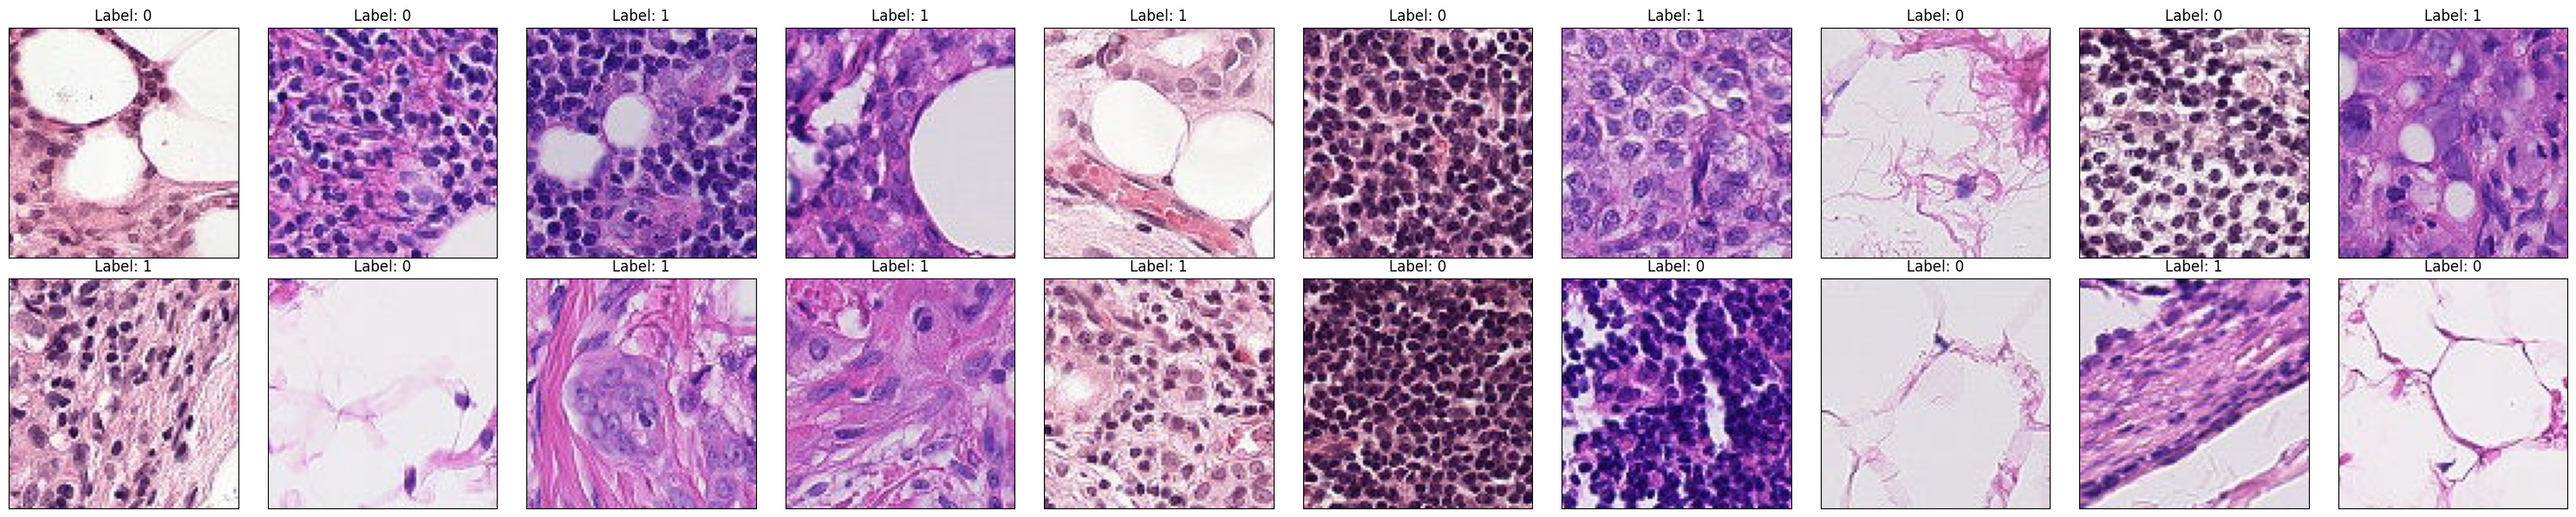

In [12]:
# Images

id_label_dict = dict(zip(trainSet['id'], trainSet['label']))
train_imgs = os.listdir(directory + "train")
chosen_imgs = np.random.choice(train_imgs, 20, replace=False)
fig, axes = plt.subplots(2, 10, figsize=(30, 6))
axes = axes.flatten()

for idx, img in enumerate(chosen_imgs):
    openImg = Image.open(directory + "train/" + img)
    axes[idx].imshow(openImg)
    label = id_label_dict.get(img.split('.')[0])
    axes[idx].set_title(f'Label: {label}')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.tight_layout()

## Exploratory Data Analysis

### Data Cleaning

In [7]:
# Reference: https://www.kaggle.com/code/grapeseed/cnn-cancer-detection

def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(directory + f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)

def process_images(image_files, labels=[], with_label=True, subset='train'):

    for index, filename in enumerate(tqdm(image_files)):
        label = labels[index] if with_label else 0
        convert_image(filename, label, with_label, subset)


In [8]:
process_images((trainSet['id'] + '.tif').values.tolist(), labels=trainSet['label'].values.tolist())

  0%|          | 0/220025 [00:00<?, ?it/s]

100%|██████████| 220025/220025 [22:20<00:00, 164.12it/s]


In [9]:
process_images(os.listdir(directory + "test"), with_label=False, subset='test')


100%|██████████| 57458/57458 [13:41<00:00, 69.93it/s]


### Set up data and processing efficiency

In [13]:
base_png_dir = os.path.join(notebook_dir, 'png')

# Training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_png_dir, 'train'), 
    label_mode='binary',
    image_size=(96,96), 
    seed=42,
    validation_split=0.2,
    subset='training',
    batch_size=128
)

# Validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_png_dir, 'train'), 
    label_mode='binary',
    image_size=(96,96), 
    seed=42,
    validation_split=0.2,
    subset='validation',
    batch_size=128
)

# Test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_png_dir, 'test'),
    label_mode=None,
    image_size=(96,96),
    shuffle=False,
    batch_size=1
)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.
Found 57458 files belonging to 1 classes.


Improve I/O efficiency

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Cache images to improve processing time

In [15]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Reduce overfitting/improve generalization

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Normalize data

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x: normalization_layer(x))

Shuffle to avoid bias

In [18]:
train_dataset = train_dataset.shuffle(buffer_size=1000).cache().prefetch(buffer_size=AUTOTUNE)

### Visual exploration

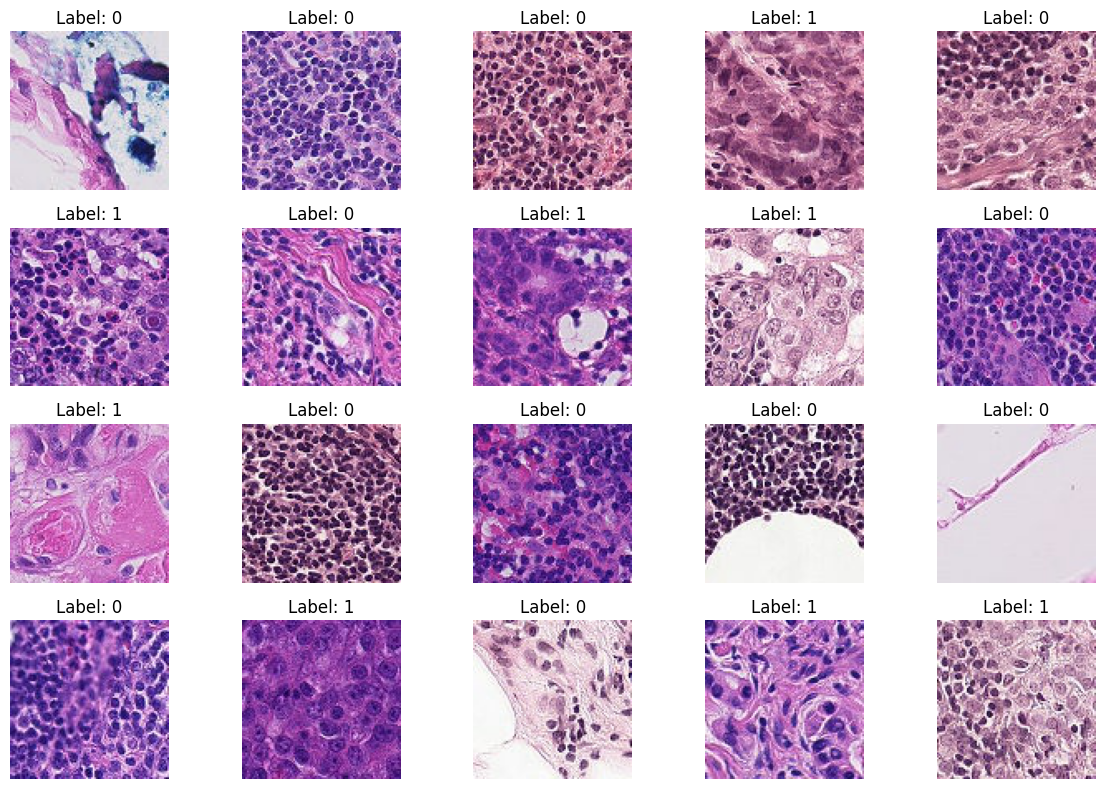

In [19]:
# sample images w/ labels

plt.figure(figsize=(12, 8))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    img_id = np.random.choice(trainSet['id'])
    img_label = trainSet[trainSet['id'] == img_id]['label'].values[0]
    img_path = os.path.join(directory, f"train/{img_id}.tif")
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Label: {img_label}")
    plt.axis('off')
plt.tight_layout()

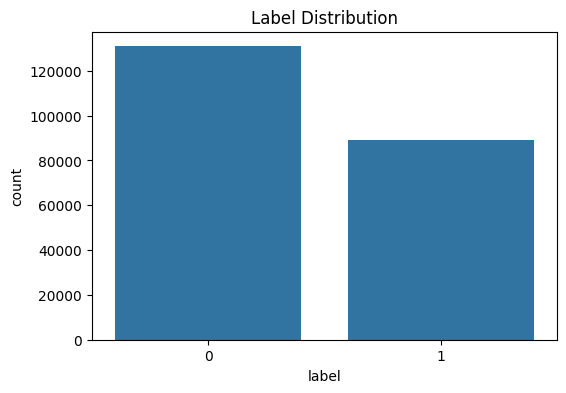

In [20]:
# label distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=trainSet)
plt.title('Label Distribution')
plt.show()

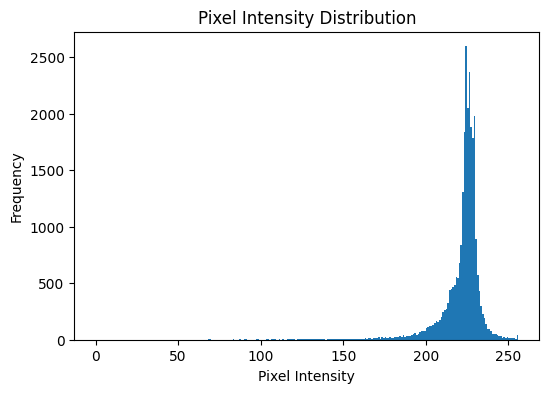

In [21]:
# pixel distribution

def plot_image_intensity_distribution(img):
    plt.hist(img.ravel(), bins=256, range=[0,256])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

img_id = np.random.choice(trainSet['id'])
img_path = os.path.join(directory, f"train/{img_id}.tif")
img = Image.open(img_path)
img_np = np.array(img)

plt.figure(figsize=(6, 4))
plot_image_intensity_distribution(img_np)
plt.title('Pixel Intensity Distribution')
plt.show()

### Plan of Analysis

I will use a CNN, which is good for image classification tasks because it can capture spatial hierarchies in image data. I will follow with the kerastuner for hyperparameter optimization. 

## Model

### Description & Reasoning

I'll start with a rescaling layer to normalize and stablize the data, which can improve training speed. The model then uses a series of Conv2D layers, each followed by a MaxPooling2D layer, to extract and condense features from the images. The Conv2D layers with different filter sizes (32, 64, and 128) will capture more complex patterns. After these layers, I'll flatten the output to prepare for the dense layers with 64 and 32 neurons respectively, which will perform classification based on the features extracted and condensed by the other layers. The final output layer uses a sigmoid activation function for binary classification. To enhance the model's performance, I will consider implementing batch normalization and dropout layers in future iterations to control covariate shift and prevent overfitting. Additionally, I plan to employ the hyperband algorithm for hyperparameter optimization to seek good validation accuracy and I may include early stopping during training for efficiency and to prevent overtraining, if required or beneficial.

### Model Code

In [45]:
# Model
# Reference: https://www.kaggle.com/code/grapeseed/cnn-cancer-detection

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        416       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 128)        

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [48]:
history = model.fit(train_dataset, 
                    epochs=10, 
                    validation_data=val_dataset, 
                    verbose=1)

Epoch 1/10


1376/1376 [==============================] - 184s 132ms/step - loss: 0.6530 - accuracy: 0.5942 - val_loss: 0.6192 - val_accuracy: 0.5973
Epoch 2/10
1376/1376 [==============================] - 143s 104ms/step - loss: 0.6182 - accuracy: 0.5949 - val_loss: 0.6123 - val_accuracy: 0.5973
Epoch 3/10
1376/1376 [==============================] - 135s 98ms/step - loss: 0.6076 - accuracy: 0.6356 - val_loss: 0.6004 - val_accuracy: 0.6575
Epoch 4/10
1376/1376 [==============================] - 132s 96ms/step - loss: 0.5845 - accuracy: 0.6777 - val_loss: 0.5645 - val_accuracy: 0.7039
Epoch 5/10
1376/1376 [==============================] - 133s 97ms/step - loss: 0.5529 - accuracy: 0.7124 - val_loss: 0.5244 - val_accuracy: 0.7426
Epoch 6/10
1376/1376 [==============================] - 130s 95ms/step - loss: 0.5115 - accuracy: 0.7505 - val_loss: 0.4938 - val_accuracy: 0.7668
Epoch 7/10
1376/1376 [==============================] - 209s 152ms/step - loss: 0.4911 - accuracy: 0.7668 - val_loss: 0.4843 - 

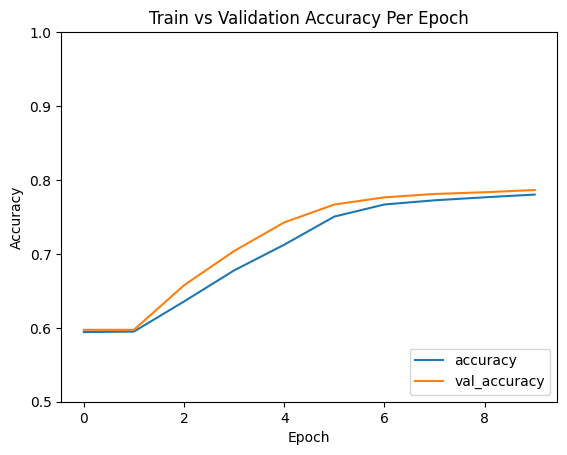

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Train vs Validation Loss Per Epoch')

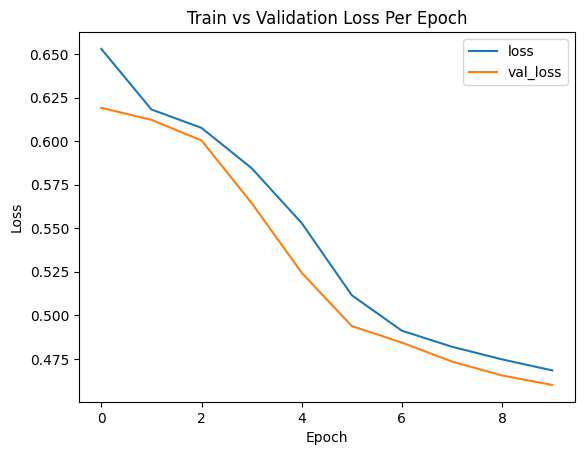

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

## Submission Creation

In [51]:
# Create submission entry

test_imgs = os.listdir("png/test")
model1_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)
predictions = model.predict(test_dataset)
model1_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model1_pred_df['label'] = np.round(predictions.flatten()).astype('int')
model1_pred_df
model1_pred_df.to_csv('predictions_no_tuning.csv', index=False)

57458/57458 [==============================] - 156s 3ms/step


Achieved a public score of 0.7806. We will proceed to tuning to see if we can get a better score. 

## Results

### Before tuning

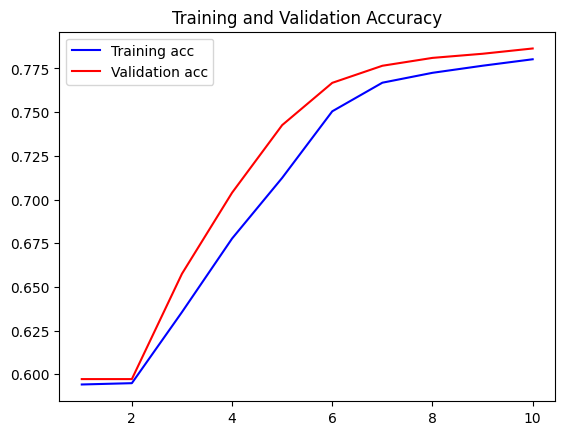

In [52]:
# training/validation accuracy: Shows how the accuracy on the training and validation sets evolved during training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

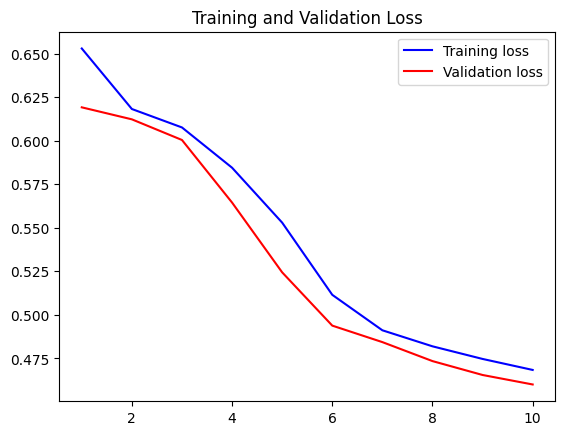

In [53]:
# training/validation loss: Displays the loss on the training and validation sets throughout the training epochs

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

344/344 [==============================] - 13s 37ms/step


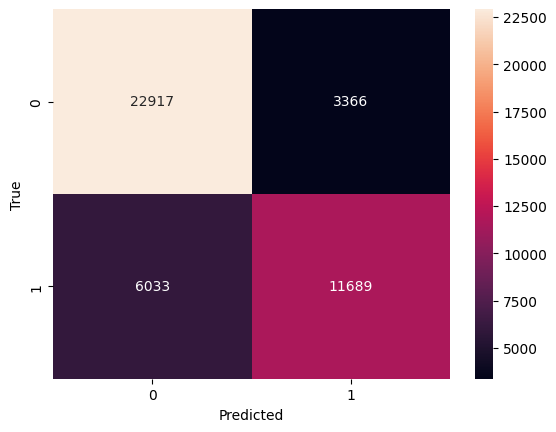

In [54]:
# confusion matrix: Helps in understanding the true positives, true negatives, false positives, and false negatives

val_predictions = model.predict(val_dataset)
val_predictions = [1 if x > 0.5 else 0 for x in val_predictions]

# True labels
val_labels = []
for images, labels in val_dataset.unbatch():
    val_labels.extend(labels.numpy())

cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Hyperparameter Optimization

In [22]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(96,96,3)))
    model.add(tf.keras.layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
    model.add(tf.keras.layers.Flatten())

    # Define hyperparameters for dense layers
    hp_units_1 = hp.Int('dense_1_units', min_value=32, max_value=128, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation='relu'))

    hp_units_2 = hp.Int('dense_2_units', min_value=16, max_value=64, step=16)
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.summary()

    # Learning rate hyperparameter
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [23]:
# Tuner setup
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperband_tuning',  # Specify directory to save tuner results
                     project_name='my_project')

# Tuner search
tuner.search(train_dataset, epochs=10, validation_data=val_dataset)  # epochs should match max_epochs in tuner

# Retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The best number of units in the first dense layer: {best_hps.get('dense_1_units')}")
print(f"The best number of units in the second dense layer: {best_hps.get('dense_2_units')}")
print(f"The best learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 09m 01s]
val_accuracy: 0.7413021326065063

Best val_accuracy So Far: 0.7651403546333313
Total elapsed time: 01h 55m 21s
The best number of units in the first dense layer: 128
The best number of units in the second dense layer: 64
The best learning rate: 0.0001


### After tuning


In [24]:
# Tuned Model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(tf.keras.layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        416       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)        

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # based on tuning
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=val_dataset, 
    verbose=1
)

Epoch 1/10


1376/1376 [==============================] - 51s 36ms/step - loss: 0.6742 - accuracy: 0.5943 - val_loss: 0.6626 - val_accuracy: 0.5973
Epoch 2/10
1376/1376 [==============================] - 53s 39ms/step - loss: 0.5347 - accuracy: 0.7404 - val_loss: 0.5592 - val_accuracy: 0.7333
Epoch 3/10
1376/1376 [==============================] - 58s 42ms/step - loss: 0.5008 - accuracy: 0.7695 - val_loss: 0.5541 - val_accuracy: 0.7361
Epoch 4/10
1376/1376 [==============================] - 57s 42ms/step - loss: 0.4947 - accuracy: 0.7741 - val_loss: 0.5504 - val_accuracy: 0.7384
Epoch 5/10
1376/1376 [==============================] - 58s 42ms/step - loss: 0.4907 - accuracy: 0.7770 - val_loss: 0.5394 - val_accuracy: 0.7461
Epoch 6/10
1376/1376 [==============================] - 58s 42ms/step - loss: 0.4870 - accuracy: 0.7790 - val_loss: 0.5358 - val_accuracy: 0.7496
Epoch 7/10
1376/1376 [==============================] - 58s 42ms/step - loss: 0.4843 - accuracy: 0.7806 - val_loss: 0.5321 - val_accura

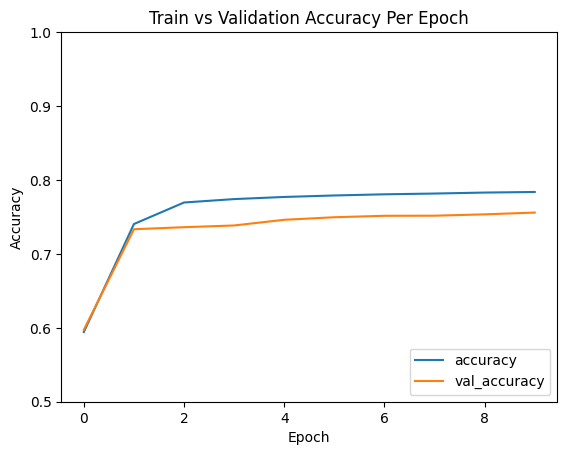

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Train vs Validation Loss Per Epoch')

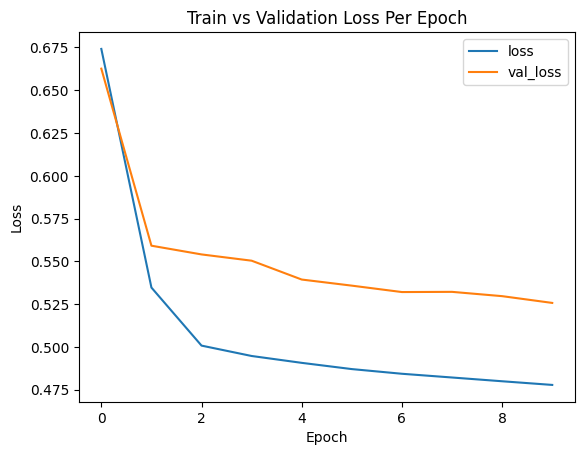

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

In [29]:
# Create submission entry

test_imgs = os.listdir("png/test")
model1_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)
predictions = model.predict(test_dataset)
model1_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model1_pred_df['label'] = np.round(predictions.flatten()).astype('int')
model1_pred_df
model1_pred_df.to_csv('predictions_with_tuning_3.csv', index=False)

57458/57458 [==============================] - 180s 3ms/step


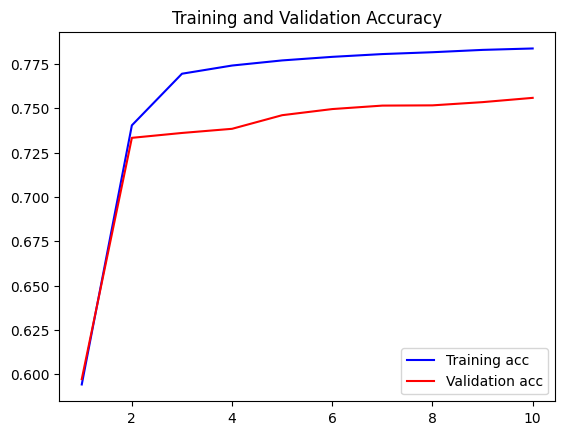

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

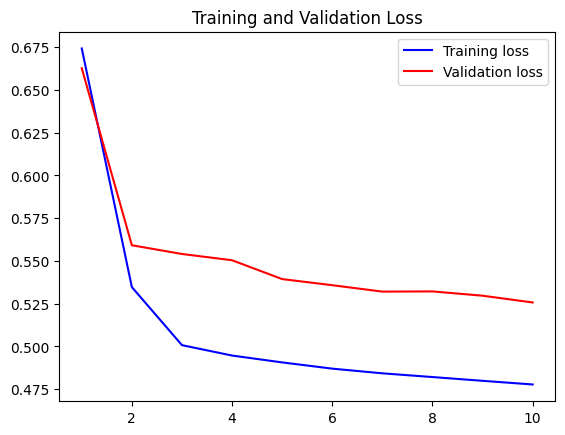

In [33]:
# training/validation loss: Displays the loss on the training and validation sets throughout the training epochs

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

344/344 [==============================] - 5s 14ms/step


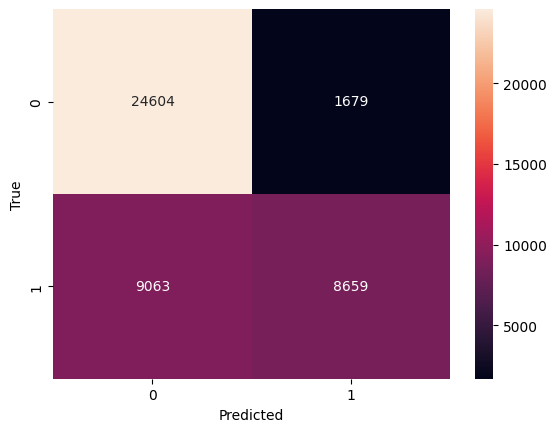

In [34]:
# confusion matrix: Helps in understanding the true positives, true negatives, false positives, and false negatives

val_predictions = model.predict(val_dataset)
val_predictions = [1 if x > 0.5 else 0 for x in val_predictions]

# True labels
val_labels = []
for images, labels in val_dataset.unbatch():
    val_labels.extend(labels.numpy())

cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Analysis

The current CNN with hyperparameter tuning performed well. I complexity of the network isa good balance of accuracy and computational efficiency. Improvements could have been making the model a bit more complicated and adding additional layers to process the complexities of the data. In addition, I could have run the hyperBand tuner for longer to see if there were better parameters available given more computing resources. 


## Conclusion

Overall, the process went well. I got a good (not great) public score on the competition. The hyperparameter optimization did not go as well as I would have liked. Re-running the model resulted in a public score of 0.733 which was a decrease from the original model score at 0.7806. 
